## Part1: For this project, you should look at requests with Request Type of "COVID-19" and Subrequest Type of "COVID-19 Violations". 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

%matplotlib inline

In [2]:
# to see all columns
pd.set_option('display.max_columns', None)

### 1-Using Json files:

In [3]:
#getting data from API, case_requests = COVID-19 and setting limit to 25k

url = 'https://data.nashville.gov/resource/7qhx-rexh.json?case_request=COVID-19&$limit=25000'

response = requests.get(url)

In [4]:
#reading the json text to dataframe

hubNashville = pd.read_json(response.text)

In [5]:
#subsetting for case_request and case_subrequest

covid19 = hubNashville[hubNashville["case_subrequest"] == "COVID-19 Violations"]

In [6]:
covid19.shape

(11797, 19)

In [7]:
#drop columns
covid19 = covid19.drop(columns = ["additional_subrequest","case_subrequest", "case_origin", "mapped_location", "parent_case"], axis = 1)

In [8]:
covid19.shape

(11797, 14)

In [9]:
covid19.head(2)

,case_number,case_request,closed_when_created,contact_type,date_time_closed,date_time_opened,incident_address,incident_city,incident_council_district,incident_zip_code,latitude,longitude,state_issue,status
0,500344,COVID-19,False,NaN,NaN,2020-11-11T19:00:02.000,2605 8th Ave S,NASHVILLE,17.0,37204.0,36.121914,-86.776085,False,New
1,500258,COVID-19,False,NaN,NaN,2020-11-11T15:07:52.000,1003 3rd Ave S,NASHVILLE,17.0,37210.0,36.148851,-86.768425,False,New


### 2-Convert the time

In [10]:
# Converting the original date column from string to datetime
covid19["date_opened"] = covid19["date_time_opened"].astype("datetime64")

covid19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11797 entries, 0 to 16196
Data columns (total 15 columns):
case_number                  11797 non-null int64
case_request                 11797 non-null object
closed_when_created          11797 non-null object
contact_type                 46 non-null object
date_time_closed             11735 non-null object
date_time_opened             11797 non-null object
incident_address             11520 non-null object
incident_city                10807 non-null object
incident_council_district    10840 non-null float64
incident_zip_code            10872 non-null float64
latitude                     11518 non-null float64
longitude                    11518 non-null float64
state_issue                  11797 non-null object
status                       11797 non-null object
date_opened                  11797 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(9)
memory usage: 1.4+ MB


In [11]:
covid19['month_opened'] = covid19['date_opened'].dt.month
covid19['day_opened'] = covid19['date_opened'].dt.day
covid19['time_opened'] = covid19['date_opened'].dt.time

covid19.head()

,case_number,case_request,closed_when_created,contact_type,date_time_closed,date_time_opened,incident_address,incident_city,incident_council_district,incident_zip_code,latitude,longitude,state_issue,status,date_opened,month_opened,day_opened,time_opened
0,500344,COVID-19,False,NaN,NaN,2020-11-11T19:00:02.000,2605 8th Ave S,NASHVILLE,17.0,37204.0,36.121914,-86.776085,False,New,2020-11-11 19:00:02,11,11,19:00:02
1,500258,COVID-19,False,NaN,NaN,2020-11-11T15:07:52.000,1003 3rd Ave S,NASHVILLE,17.0,37210.0,36.148851,-86.768425,False,New,2020-11-11 15:07:52,11,11,15:07:52
2,500246,COVID-19,False,NaN,NaN,2020-11-11T14:18:24.000,1612 Elm Hill Pike,NASHVILLE,15.0,37210.0,36.144422,-86.715437,False,New,2020-11-11 14:18:24,11,11,14:18:24
3,500414,COVID-19,False,NaN,NaN,2020-11-11T22:34:37.000,174 3rd Ave N,NASHVILLE,19.0,37201.0,36.163657,-86.777299,False,New,2020-11-11 22:34:37,11,11,22:34:37
4,500409,COVID-19,False,NaN,NaN,2020-11-11T22:24:35.000,410 39th Ave N,NASHVILLE,24.0,37209.0,36.153211,-86.832682,False,New,2020-11-11 22:24:35,11,11,22:24:35


In [12]:
covid19["month_day_opened"] = covid19['date_opened'].dt.strftime('%m-%d') # from Taylor

In [13]:
# drop "date_time_opened"
covid19 = covid19.drop(columns = ["date_time_opened"], axis = 1)

In [14]:
# NB: there is missing values and this is why I can't convert the closed dates in integer (can't if Nan values) but I shouldn't need it for the project
#covid19[["month_closed", "day_closed"]] = covid19[["month_closed", "day_closed"]].apply(pd.to_numeric)
#covid19.info()

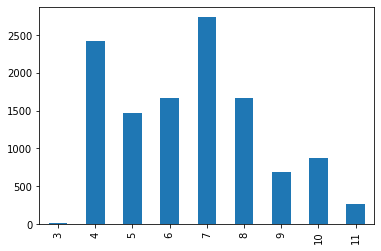

In [15]:
covid19['month_opened'].value_counts().sort_index().plot(kind="bar");

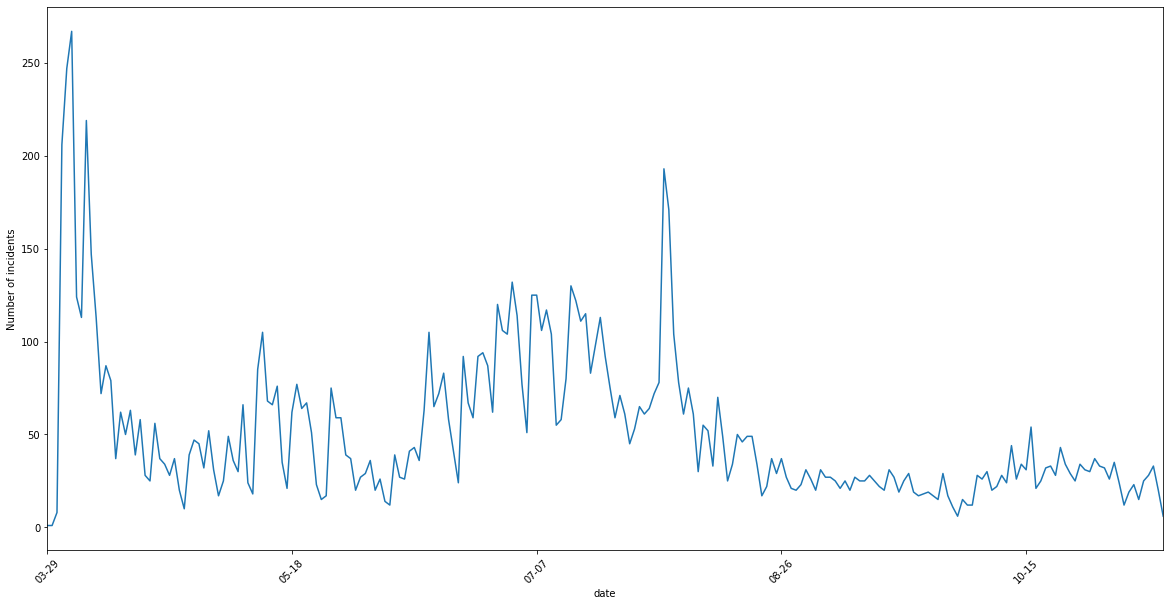

In [16]:
ax= covid19['month_day_opened'].value_counts().sort_index().plot(rot=45, figsize=(20, 10))

ax.set_xlabel("date")
ax.set_ylabel("Number of incidents");

In [17]:
#covid19['log'] = covid19['GDP_Per_Capita'].apply(np.log)

## Part2: file davidson_cases.csv

### The file davidson_cases.csv contains the number of COVID cases in Davidson county per day from March 8 through October 29. Use this dataset to compare the trend for the number of cases over time to the number of reported violations. Feel free to add any additional data that you think might be useful.

In [18]:
davidson_cases = pd.read_csv("../data/davidson_cases.csv")
davidson_cases.head()

,date,county,state,fips,cases,deaths
0,2020-03-08,Davidson,Tennessee,47037,1,0
1,2020-03-09,Davidson,Tennessee,47037,1,0
2,2020-03-10,Davidson,Tennessee,47037,1,0
3,2020-03-11,Davidson,Tennessee,47037,2,0
4,2020-03-12,Davidson,Tennessee,47037,6,0


### 1-Convert the time

In [19]:
# Converting the original date column from string to datetime
davidson_cases["date"] = davidson_cases["date"].astype("datetime64")

davidson_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 6 columns):
date      235 non-null datetime64[ns]
county    235 non-null object
state     235 non-null object
fips      235 non-null int64
cases     235 non-null int64
deaths    235 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.1+ KB


In [20]:
davidson_cases['month'] = davidson_cases['date'].dt.month
davidson_cases['day'] = davidson_cases['date'].dt.day

davidson_cases.head()

,date,county,state,fips,cases,deaths,month,day
0,2020-03-08,Davidson,Tennessee,47037,1,0,3,8
1,2020-03-09,Davidson,Tennessee,47037,1,0,3,9
2,2020-03-10,Davidson,Tennessee,47037,1,0,3,10
3,2020-03-11,Davidson,Tennessee,47037,2,0,3,11
4,2020-03-12,Davidson,Tennessee,47037,6,0,3,12


In [21]:
davidson_cases["month_day"] = davidson_cases['date'].dt.strftime('%m-%d')

### 2-Compare the number of cases and the number of reported violations over time:

In [22]:
# making a df of month and day opened # from Taylor
violations_by_day = covid19.groupby('month_day_opened').size().to_frame('count')

In [23]:
violations_by_day.head(3)

,count
month_day_opened,
03-29,1
03-30,1
03-31,8


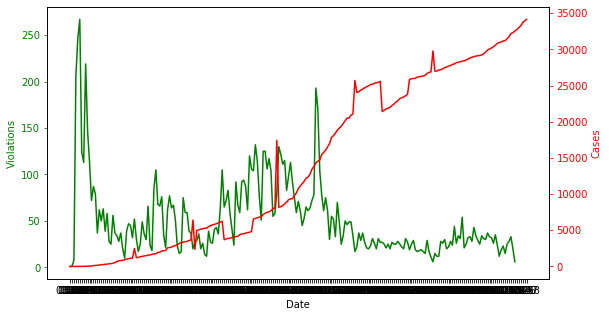

In [24]:
# from Taylor
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(violations_by_day.index, violations_by_day['count'], 
           color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Violations', color='green')
ax.tick_params('y', colors='green')
ax2 = ax.twinx()
ax2.plot(davidson_cases['month_day'], davidson_cases['cases'],          
         color='red')
ax2.set_ylabel('Cases', color='red')
ax2.tick_params('y', colors='red');

### 3-Exploring the number of deaths and cases over time:

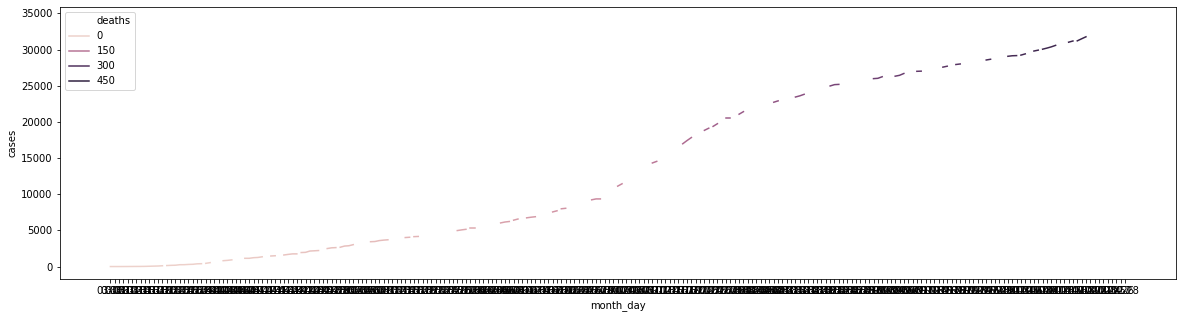

In [25]:
plt.figure(figsize=(20,5))
sns.lineplot(data= davidson_cases,x ="month_day",y="cases", hue="deaths");

In [26]:
#plt.figure(figsize=(20,5))
#sns.scatterplot(data= davidson_cases,x ="month_day",y="cases", hue="deaths")
#plt.xticks(rotation = 45);

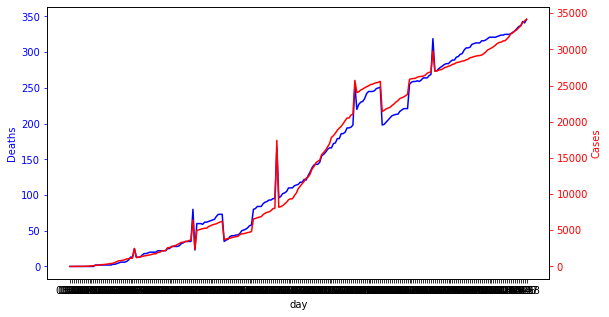

In [27]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(davidson_cases['month_day'], davidson_cases['deaths'], 
           color='blue')
ax.set_xlabel('day')
ax.set_ylabel('Deaths', color='blue')
ax.tick_params('y', colors='blue')
ax2 = ax.twinx()
ax2.plot(davidson_cases['month_day'], davidson_cases['cases'],          
         color='red')
ax2.set_ylabel('Cases', color='red')
ax2.tick_params('y', colors='red');

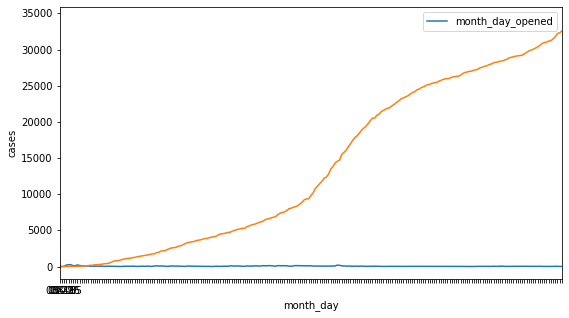

In [28]:
plt.figure(figsize=(9,5))

covid19['month_day_opened'].value_counts().sort_index().plot()

sns.lineplot(data= davidson_cases,x ="month_day",y="cases");

## Part3: The Metro Public Health Department tracks COVID-19 clusters.

### The files 'clusters.csv' and 'clusters_by_type.csv' contain the tables of clusters as reported by [WSMV](https://www.wsmv.com/news/metro-health-releases-latest-covid-19-clusters/article_ef554e08-1558-11eb-b290-873345e174d7.html) along with the coordinates of the clusters. Can you find any connection between the reported COVID violations and subsequent COVID clusters?

### 1-Open cluster file

In [29]:
cluster_by_type = pd.read_csv("../data/clusters_by_type.csv")
                              
cluster_by_type.head()

,Cluster Type,Number of Clusters
0,Bar,7
1,Church,2
2,College / University,5
3,Commercial-Warehouse,12
4,Congregate Living,13


In [30]:
cluster_by_type["Cluster Type"].unique()

array(['Bar', 'Church', 'College / University', 'Commercial-Warehouse',
       'Congregate Living', 'Construction', 'Correctional Facility',
       'Day Care', 'Food Production', 'Grocery', 'Gym',
       'Healthcare, non-LTCF', 'LTCF', 'Office', 'Other', 'Restaurant',
       'School', 'Social Gathering'], dtype=object)

In [31]:
cluster_by_type = cluster_by_type.rename(columns = {"Cluster Type":"facility_type", "Number of Clusters":"number_clusters"})

In [32]:
cluster_by_type.shape

(18, 2)

### 2-Open cluster file

In [33]:
cluster = pd.read_csv("../data/clusters_revised.csv")
cluster.head()

,Cluster Name,Facility Type,Cluster Start Date,# Cases,Latitude,Longitude
0,Vanderbilt Parties,Social Gathering,3/11/2020,49,36.144703,-86.802655
1,Event at Clementine Hall,Social Gathering,3/14/2020,23,36.152444,-86.844583
2,Religious Retreat,Social Gathering,3/25/2020,18,NaN,NaN
3,The Health Center at Richland Place,LTCF,4/3/2020,47,36.128750,-86.817345
4,Trevecca Center for Rehab and Healing,LTCF,4/4/2020,102,36.144562,-86.754560


In [34]:
cluster["Facility Type"].unique()

array(['Social Gathering', 'LTCF', 'Commercial-Warehouse',
       'Correctional Facility', 'Congregate Living', 'Other',
       'Construction', 'Bar', 'Restaurant', 'Office',
       'College / University', 'School', 'Church', 'Gym'], dtype=object)

In [35]:
cluster = cluster.rename(columns = {"Cluster Name":"cluster_name", "Facility Type":"facility_type","Cluster Start Date":"cluster_date", "# Cases":"#_cases", "Latitude":"latitude", "Longitude":"longitude"})

In [36]:
cluster.head()

,cluster_name,facility_type,cluster_date,#_cases,latitude,longitude
0,Vanderbilt Parties,Social Gathering,3/11/2020,49,36.144703,-86.802655
1,Event at Clementine Hall,Social Gathering,3/14/2020,23,36.152444,-86.844583
2,Religious Retreat,Social Gathering,3/25/2020,18,NaN,NaN
3,The Health Center at Richland Place,LTCF,4/3/2020,47,36.128750,-86.817345
4,Trevecca Center for Rehab and Healing,LTCF,4/4/2020,102,36.144562,-86.754560


In [37]:
#drop NaNs values in longitude and latitude columns
cluster = cluster.dropna() 

In [38]:
cluster.shape

(51, 6)

In [39]:
# there is a comma before one longitude coordinate and I need to remove it and I'm using strip (not anymore with the revised file)
#cluster["longitude"] = cluster["longitude"].str.strip(",")

In [40]:
# convert Longitude object to a float
#cluster["longitude"] = cluster.longitude.astype(float)

### 3-Merge cluster and cluster by type (NB: there is more categories in cluster by type so I will merge it on the cluster df)

In [41]:
cluster_merge = cluster.merge(cluster_by_type, on="facility_type", how="left")

In [42]:
cluster_merge.shape

(51, 7)

### 4-Make the geometry column for geospatial:

In [43]:
cluster_merge['geometry'] = cluster_merge.apply(lambda x: Point((float(x.longitude), 
                                                         float(x.latitude))), 
                                        axis=1)
cluster_merge.head(3)

,cluster_name,facility_type,cluster_date,#_cases,latitude,longitude,number_clusters,geometry
0,Vanderbilt Parties,Social Gathering,3/11/2020,49,36.144703,-86.802655,12,POINT (-86.8026551 36.1447034)
1,Event at Clementine Hall,Social Gathering,3/14/2020,23,36.152444,-86.844583,12,POINT (-86.84458290000001 36.15244420000001)
2,The Health Center at Richland Place,LTCF,4/3/2020,47,36.128750,-86.817345,39,POINT (-86.8173446 36.12874979999999)


### 5-Add davidson county with zipcodes

In [44]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)
zipcodes.head( )

{'init': 'epsg:4326'}


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"(POLYGON ((-86.68724897141 36.318212121092, -8..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"(POLYGON ((-86.734511869193 36.237735044539, -..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"(POLYGON ((-86.779138251631 36.134238084457, -..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"(POLYGON ((-86.812577055527 36.063187757856, -..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"(POLYGON ((-87.02196675255701 36.011997336279,..."


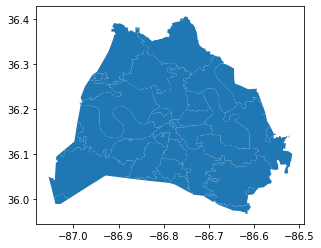

In [45]:
zipcodes.plot();

In [46]:
zipcodes.crs

{'init': 'epsg:4326'}

### 6-Make the geodataframe for cluster file and make a map:

In [48]:
cluster_merge_geo = gpd.GeoDataFrame(cluster_merge, 
                           crs = zipcodes.crs, 
                           geometry = cluster_merge['geometry'])

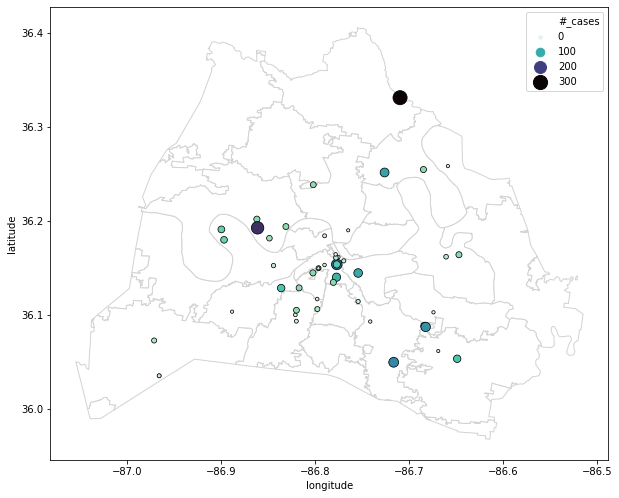

In [49]:
ax = zipcodes.plot(figsize = (10, 10), color = 'white', edgecolor = 'lightgrey')

sns.scatterplot(data=cluster_merge, x="longitude", y="latitude", hue="#_cases", palette="mako_r", size="#_cases", sizes=(10, 200), edgecolor = 'black');

### 7-Convert the covid19 violation file into a geodataframe:

In [50]:
#drop NaNs values in longitude and latitude columns
covid19 = covid19.dropna() 

In [51]:
covid19['geometry'] = covid19.apply(lambda x: Point((float(x.longitude), 
                                                         float(x.latitude))), 
                                        axis=1)
covid19.head(3)

,case_number,case_request,closed_when_created,contact_type,date_time_closed,incident_address,incident_city,incident_council_district,incident_zip_code,latitude,longitude,state_issue,status,date_opened,month_opened,day_opened,time_opened,month_day_opened,geometry
308,493482,COVID-19,False,Other,2020-11-03T15:51:08.000,3904 Dickerson Pike,NASHVILLE,3.0,37207.0,36.270091,-86.755760,False,Closed,2020-11-02 18:36:00,11,2,18:36:00,11-02,POINT (-86.75575959999999 36.2700907)
699,487670,COVID-19,False,Other,2020-10-26T14:26:52.000,8080 C TN-100,NASHVILLE,35.0,37221.0,36.046261,-86.954442,False,Closed,2020-10-24 02:01:22,10,24,02:01:22,10-24,POINT (-86.9544418528676 36.04626128173544)
1010,482840,COVID-19,False,Resident,2020-10-19T16:01:12.000,816 Madison Square,MADISON,8.0,37115.0,36.254811,-86.716097,False,Closed,2020-10-17 17:26:43,10,17,17:26:43,10-17,POINT (-86.71609673649073 36.25481055837834)


In [52]:
covid19_geo = gpd.GeoDataFrame(covid19, 
                           crs = zipcodes.crs, 
                           geometry = covid19['geometry'])

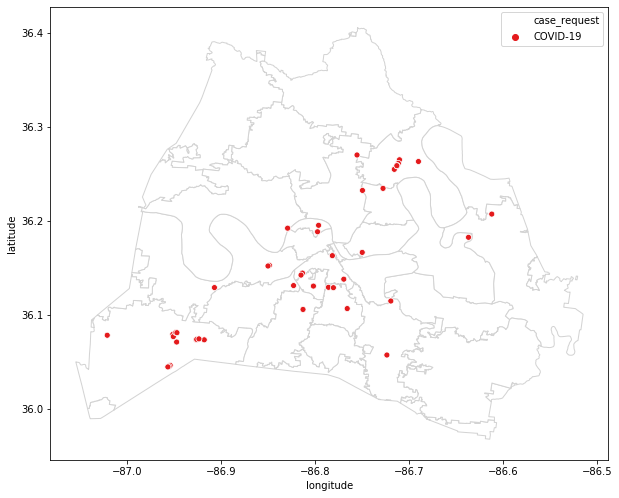

In [53]:
ax = zipcodes.plot(figsize = (10, 10), color = 'white', edgecolor = 'lightgrey')

sns.scatterplot(data=covid19_geo, x="longitude", y="latitude", hue="case_request",palette="Set1");

#sns.scatterplot(data=cluster_merge_geo, x="longitude", y="latitude", hue="#_cases", palette="mako_r", size="#_cases", sizes=(10, 200), edgecolor = 'black');

### Making a heat map:

In [54]:
covid19_merge = (covid19
          .drop(columns = 'geometry')
          .rename(columns = {'incident_zip_code': 'zip'})
         )

In [55]:
# zip was a float
covid19_merge['zip'] = covid19_merge['zip'].astype(int)

In [56]:
# to get the count per zipcode
covid19_merge_gpby = covid19_merge.groupby("zip")["closed_when_created"].agg('count')
covid19_merge_gpby.head()

zip
37076    1
37115    6
37203    3
37204    3
37205    1
Name: closed_when_created, dtype: int64

In [57]:
covid19_merge_gpby = covid19_merge_gpby.to_frame()

In [58]:
covid19_merge_gpby = covid19_merge_gpby.reset_index()

In [59]:
covid19_merge_gpby.head()

,zip,closed_when_created
0,37076,1
1,37115,6
2,37203,3
3,37204,3
4,37205,1


In [61]:
zipcodes['zip'] = zipcodes['zip'].astype(int)

In [62]:
zipcodes_covid19_merge = pd.merge(left = covid19_merge, right = zipcodes)

In [63]:
zipcodes_covid19_merge.head(2)

,case_number,case_request,closed_when_created,contact_type,date_time_closed,incident_address,incident_city,incident_council_district,zip,latitude,longitude,state_issue,status,date_opened,month_opened,day_opened,time_opened,month_day_opened,objectid,po_name,shape_stlength,shape_starea,geometry
0,493482,COVID-19,False,Other,2020-11-03T15:51:08.000,3904 Dickerson Pike,NASHVILLE,3.0,37207,36.270091,-86.75576,False,Closed,2020-11-02 18:36:00,11,2,18:36:00,11-02,49,NASHVILLE,14456.130686344946,6987521.0933837891,"(POLYGON ((-86.785957994862 36.290972726055, -..."
1,493482,COVID-19,False,Other,2020-11-03T15:51:08.000,3904 Dickerson Pike,NASHVILLE,3.0,37207,36.270091,-86.75576,False,Closed,2020-11-02 18:36:00,11,2,18:36:00,11-02,48,NASHVILLE,196775.60104082408,556772811.32653809,"(POLYGON ((-86.754591258375 36.290206559301, -..."


In [64]:
zipcodes_covid19_merge_gpby = zipcodes.merge(covid19_merge_gpby, on="zip", how="outer")

In [65]:
zipcodes_covid19_merge_gpby.head()

,zip,objectid,po_name,shape_stlength,shape_starea,geometry,closed_when_created
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"(POLYGON ((-86.68724897141 36.318212121092, -8...",6.0
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"(POLYGON ((-86.734511869193 36.237735044539, -...",2.0
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"(POLYGON ((-86.779138251631 36.134238084457, -...",3.0
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"(POLYGON ((-86.812577055527 36.063187757856, -...",NaN
4,37027,31,BRENTWOOD,3116.4327152718852,304596.06201171875,"(POLYGON ((-86.72012412992601 36.008864004587,...",NaN


In [66]:
zipcodes_covid19_merge_gpby['closed_when_created'] = zipcodes_covid19_merge_gpby['closed_when_created'].fillna(0)

In [67]:
zipcodes_covid19_merge_gpby['closed_when_created'] = zipcodes_covid19_merge_gpby['closed_when_created'].astype(int)

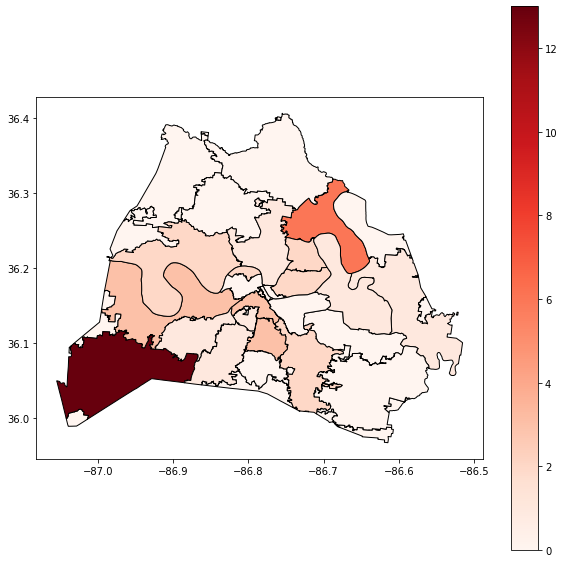

In [68]:
#Heat map of covid violations per zipcodes in davidson county

fig, ax = plt.subplots(figsize=(10,10))
zipcodes_covid19_merge_gpby.plot(column = 'closed_when_created', 
                                 cmap = 'Reds', 
                                 edgecolor = 'black', 
                                 legend = True,
                                 ax = ax);

### 8-Map covid-19 violations and clusters cases on the davidson shape map:

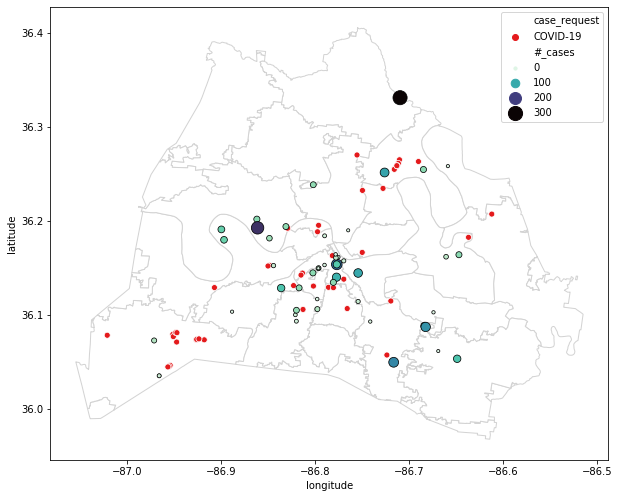

In [69]:
ax = zipcodes.plot(figsize = (10, 10), color = 'white', edgecolor = 'lightgrey')

sns.scatterplot(data=covid19_geo, x="longitude", y="latitude", hue="case_request",palette="Set1");

sns.scatterplot(data=cluster_merge_geo, x="longitude", y="latitude", hue="#_cases", palette="mako_r", size="#_cases", sizes=(10, 200), edgecolor = 'black');

## Use Folium

In [ ]:
#zipcodes.geometry.centroid

In [70]:
center = zipcodes.geometry.centroid[1]
print(center)

POINT (-86.7263455721062 36.21605012332708)


In [71]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

[36.21605012332708, -86.7263455721062]


### 1- Map of the # of covid19 positive cases per day in davidson county:

In [72]:
#draw zipcode area
map_davidson = folium.Map(location =  area_center, zoom_start = 12)


#iterate through clusters to create locations and markers 
#remember for Folium locations, lat is listed first!!

for row_index, row_values in cluster_merge_geo.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    pop = str(row_values['#_cases'])
    marker = folium.Marker(
        location = loc, 
        popup = pop,
        icon= folium.Icon(color="blue",icon_color='white',icon = "certificate")) 
    
    marker.add_to(map_davidson)
#map_davidson.save('../maps/map_davidson.html')


#display our map
map_davidson

In [74]:
cluster_merge_geo.facility_type.unique()

array(['Social Gathering', 'LTCF', 'Commercial-Warehouse',
       'Correctional Facility', 'Congregate Living', 'Construction',
       'Bar', 'Restaurant', 'Office', 'Church', 'Other', 'Gym'],
      dtype=object)

In [75]:
# (Map will be centered at those co-ordinates)
map = folium.Map(location=[36.148465, -86.767960], default_zoom_start=10)

#Icon should be one of: {'darkred', 'lightred', 'pink', 'gray', 'lightblue', 'blue', 'red', 'lightgreen', 'darkblue' 
#, 'cadetblue', 'beige', 'green', 'lightgray', 'white', 'black', 'purple', 'orange', 'darkgreen', 'darkpurple'}.

# Function to change the marker color  
def color(facility): 
    if facility == 'Social Gathering': 
        col = 'orange'
    elif facility == 'LTCF': 
        col = 'green'
    elif facility == 'Commercial-Warehouse': 
        col = 'darkblue'
    elif facility == 'Congregate Living': 
        col = 'lightgreen'
    elif facility == 'Construction': 
        col = 'red'
    elif facility == 'Correctional Facility': 
        col = 'black'
    elif facility == 'Bar': 
        col = 'blue'
    elif facility == 'Restaurant': 
        col = 'lightgblue'
    elif facility == 'Office': 
        col = 'gray'
    elif facility == 'Church': 
        col = 'pink'
    elif facility == 'Gym': 
        col = 'purple'
    else: 
        col='white'
    return col

for row_index, row_values in cluster_merge_geo.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    pop = str(row_values['facility_type'])
    marker = folium.Marker(
        location = loc, 
        popup = pop,
        icon= folium.Icon(color=color(facility), 
                  icon_color='lightgray',icon = 'certificate')) 
    
    marker.add_to(map_davidson)
#map_davidson.save('../maps/map_davidson.html')


#display our map
map_davidson

NameError: name 'facility' is not defined

In [76]:
map = folium.Map(location=[36.148465, -86.767960], default_zoom_start=50) # from Kedir
map

### 2- Map of covid19 violations reported per day in davidson county:

In [77]:
#draw zipcode area
map_davidson = folium.Map(location =  area_center, zoom_start = 12)

#folium.GeoJson(zipcodes).add_to(map_davidson)

#iterate through #_cases to create locations and markers for covid cluster
#remember for Folium locations, lat is listed first!!

for row_index, row_values in covid19_geo.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    pop = str(row_values['case_request'])
    marker = folium.Marker(
        location = loc, 
        popup = pop,
        icon= folium.Icon(color="red",icon_color='white',icon = "hand-down")) 
    
    marker.add_to(map_davidson)
#map_davidson.save('../maps/map_davidson.html')

#display our map
map_davidson

In [78]:
#draw our zip code area: 37207
map_davidson = folium.Map(location =  area_center, zoom_start = 12)

#folium.GeoJson(zipcodes).add_to(map_davidson)

#create a list of locations and pass them to FastMarkerCluster()
locations = covid19_geo[['latitude', 'longitude']].values.tolist()
map_davidson.add_child(
    FastMarkerCluster(locations)
)

#display our map
map_davidson

## Part 4:

In [81]:
import glob
from pandas.io.json import json_normalize

In [82]:
google_results = pd.DataFrame() #create empty dataframe
for filename in glob.glob('../data/google_places_results/*.json'): # loop over .json files
    with open(filename) as f:
        google_files = json.load(f) # open the json file
        google_jsons = pd.json_normalize(google_files, sep='_', #normalize the json file for nested results
                            record_path='results')
        google_results = google_results.append(google_jsons) #append each json file results to df

AttributeError: module 'pandas' has no attribute 'json_normalize'